Dashboard building with temperature and abudannce of specific pollinators

import the necessary libraries

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

Import Data

In [10]:
df = pd.read_csv("pollinator_count_data-final.csv", sep = ',')
y = pd.read_csv("plant_on_campus_frequency.csv", sep = ',')

Clean up the imported data

In [11]:
#want to convert acronyms to full names 
#(hoverfly, honeybee, bumblebee, sweatbee, wasp, leafcutter, fly, beatle, butterfly)

def clean_data(df):

    #setting to print all the rows 
    pd.set_option('display.max_rows', None)

    #plants on campus data 
    df_frequency = pd.read_csv("plant_on_campus_frequency.csv",sep = ',')

    #convert european carder bee ( ECB), mason bee and carpenter bee to the leafcutter bee group (LF)
    df['pollinator'] = df['pollinator'].replace(['ECB','MB','CB'],'LB')
    #convert No information (NI) and unidentified bee (UB) to the Other pollinator group (OP)
    df['pollinator'] = df['pollinator'].replace(['NI','UB'],'OP')

    #replacing values within dataframe to favored/changed names exp. Bumble
    df['pollinator'] = df['pollinator'].replace(['BUT'],'Butterfly')
    df['pollinator'] = df['pollinator'].replace(['W'],'Wasp')
    df['pollinator'] = df['pollinator'].replace(['HF'],'Hover Fly')
    df['pollinator'] = df['pollinator'].replace(['BVO','BS','BMI','BME','BU','BI','BFL','BF','BB'],'Bumble')
    df['pollinator'] = df['pollinator'].replace(['SB'],'Sweat')
    df['pollinator'] = df['pollinator'].replace(['HB'],'Honey')
    df['pollinator'] = df['pollinator'].replace(['LB'],'Leaf Cutter')



    #using where statement to seperate OP to beetles and flies 

    # beetle 
    df['pollinator'] = np.where((df['pollinator'] == 'OP') & (df['insect_order'] == 'coleoptera'), 'Beetle', df['pollinator'])
    #print(df['pollinator'])

    # flies 
    df['pollinator'] =  np.where((df['pollinator'] == 'OP') & (df['insect_order'] == 'diptera'),'Fly',df['pollinator'] )
    #print(df[['pollinator','insect_order']])

    #droping all other pollinator from the data because not interested in other pollinators in data analysis
    df = df.drop(df[df['pollinator'] == 'OP'].index)
    #print(df[['pollinator','insect_order']])

    return df

In [12]:

#find the count of pollinator groups in the csv and return a percentage
pol_count = df.groupby(['pollinator'])['pollinator'].count()
print('The individual pollinator count: \n', pol_count)
print('The # of total pollinators: \n', len(df))
print('Percentage of pollinator distribution count: \n',(pol_count/len(df))*100)

The individual pollinator count: 
 pollinator
BB      13
BF       5
BFL     82
BI      32
BME     33
BMI     41
BS      12
BU       9
BUT     17
BVO    375
HB     581
HF     304
LB      20
MB       9
NI      24
OP      60
SB     267
UB       2
W       48
Name: pollinator, dtype: int64
The # of total pollinators: 
 1934
Percentage of pollinator distribution count: 
 pollinator
BB      0.672182
BF      0.258532
BFL     4.239917
BI      1.654602
BME     1.706308
BMI     2.119959
BS      0.620476
BU      0.465357
BUT     0.879007
BVO    19.389866
HB     30.041365
HF     15.718718
LB      1.034126
MB      0.465357
NI      1.240951
OP      3.102378
SB     13.805584
UB      0.103413
W       2.481903
Name: pollinator, dtype: float64


Adding in data regarding the date into seperate columns

In [76]:
def give_time(df):

    df['sample_date'] = pd.to_datetime(df['sample_date'])
    df['month'] = df['sample_date'].dt.month
    df['Week'] = df['sample_date'].dt.week -20
    df['day_of_year'] = df['sample_date'].dt.dayofweek
    
   

    #Get a column of the start of the week of all datetime objects
    df['datetime_monday_week'] = df['sample_date'].dt.to_period('W').dt.start_time
    df['dates'] = df['sample_date'].dt.strftime("%b %d, %Y")
    
    return df
	


Putting in temperature percentages

In [102]:
# A function that intakes a df column and returns a list of the percent differences with the first value being 
#the baseline percentage of 100.

def turn_into_percent_difference(old_series):
    initial_value = old_series[0]
    new_list = []
    for index in old_series:
        new_list.append((index/ initial_value)*100)
    return new_list

Define a function which would give the average temperature 

In [103]:
def line_temp_plot(data_set):
	
	#TEST to find missing temperatures in data 
	#Result : found missing time data for C0: E and C10: A --> both have no data for count in pollinator
	#must hardcode into data as no pollinator 
	count_test = data_set.groupby(['location_number','time_code'])['location_number'].count()
	count_test = count_test.reset_index(name='counts')
	#print(count_test)

	#results 
	# week = 20 , air_temp = 15, time_code = 'E', location_number = 'CO', counts = 0
	# week = 35 , air_temp = 23, time_code = 'A', location_number = 'C10', counts = 0
	#print(data_set.columns)
	num_plot_week = data_set.groupby(['Week','air_temp','time_code','location_number'])['air_temp'].count()
	num_plot_week = num_plot_week.reset_index(name = 'counts')
	pd.set_option('display.max_rows', None)
	
	num_plot_week.loc[len(num_plot_week)] = [20,15,'E','C0',0]
	num_plot_week.loc[len(num_plot_week)] = [35,23,'A','C10',0]
	#print('test_run','\n',num_plot_week)


	num_plot_week = num_plot_week.groupby(['Week'])['air_temp'].mean()
	num_plot_week = num_plot_week.reset_index(name = 'avg_air_temp')
	data_set = pd.merge(data_set, num_plot_week)
	
	#print(data_set)
	return data_set

In [104]:
def average_per_week(request):
	#observation data for pollinators
	data_set = df
	data_set = clean_data(data_set)
	data_set = give_time(data_set)
	#Test Case :1
	# #print("Test Case : 
	#1", "\n",data_set['datetime_monday_week'])
	# 
	# #find the total number of pollinators according to location number and time code
	if(request == 'average'):
		data_set['total_counts'] = data_set.groupby(['location_number','time_code'])['location_number'].transform('count')
	else:
		#print(data_set['pollinator'].unique())
		data_set = data_set[(data_set['pollinator'] == request)]
		#print(data_set)
		data_set['total_counts'] = data_set.groupby(['location_number','time_code'])['location_number'].transform('count')
	
	#Test Case :2
	#print("Test Case : 2", "\n",data_set)

	#creating average temerapture for all plots 
	data_set = line_temp_plot(data_set)


	#getting the average pollinator mean 
	data_set['pol_mean'] = data_set.groupby(['datetime_monday_week'])['total_counts'].transform('mean')

	#finding the unique average air temperature by using .last()
	data_set = data_set.groupby(['datetime_monday_week','pol_mean'])['avg_air_temp'].last()
	data_set = data_set.reset_index(name = 'avg_temp')
	#print(data_set)

	#print(data_set['dates'])
	#print(pd.to_datetime(df['dates']))
	#data_set['dates'] = pd.to_datetime(df['dates'])
	data_set = data_set.sort_values(by = 'datetime_monday_week')
	data_set['dates'] =data_set['datetime_monday_week'].dt.strftime("%b %d, %Y")
	print(data_set)

	data_set['Abundance_percentage'] = turn_into_percent_difference(data_set['pol_mean'])
	data_set['Temp_percentage'] = turn_into_percent_difference(data_set['avg_temp'])


	#plotting the graph

	fig, ax = plt.subplots()
	ax.plot(data_set['dates'], data_set['Abundance_percentage'], linewidth=3, color='#63B7B7')
	ax.plot(data_set['dates'], data_set['Temp_percentage'], linewidth=3, color='#FF6961')
	plt.xticks(rotation = 60, horizontalalignment='right')
	ax.legend(['Visitations', 'Temperature'])
	ax.set_ylabel('Percent Difference (%)')
	ax.set_xlabel('Week')
	ax.set_title('Percent Difference of Average Visition Number and \n Temperature For Each Week Between June 12 and September 11th.',
             fontname = 'Georgia', 
             fontsize= 16, 
             pad=30)
	ax.grid()

	plt.show()

	

C:\Users\lizzy\AppData\Local\Temp/ipykernel_4776/2508569428.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['Week'] = df['sample_date'].dt.week -20


   datetime_monday_week   pol_mean   avg_temp         dates
0            2022-05-23   4.176471  15.200000  May 23, 2022
1            2022-05-30   3.266667  19.166667  May 30, 2022
2            2022-06-06  13.000000  17.000000  Jun 06, 2022
3            2022-06-13  14.909091  17.000000  Jun 13, 2022
4            2022-06-20   5.296296  20.000000  Jun 20, 2022
5            2022-06-27  18.250000  21.833333  Jun 27, 2022
6            2022-07-04   1.666667  20.000000  Jul 04, 2022
7            2022-07-11   6.307692  21.400000  Jul 11, 2022
8            2022-07-18   7.384615  20.400000  Jul 18, 2022
9            2022-07-25  16.318681  27.333333  Jul 25, 2022
10           2022-08-01  18.480769  20.833333  Aug 01, 2022
11           2022-08-08  12.000000  22.666667  Aug 08, 2022
12           2022-08-15   1.000000  25.000000  Aug 15, 2022
13           2022-08-22   1.000000  23.500000  Aug 22, 2022
14           2022-08-29   8.071429  25.571429  Aug 29, 2022
15           2022-09-05   3.615385  18.0

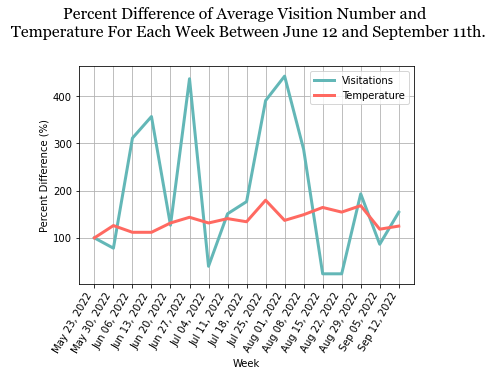

In [105]:
#print(df)
average_per_week('Bumble')

Starting the building of a dashboard
import the necessary libraries

In [106]:

import plotly.express as px

import ipywidgets as widgets

import calendar

#from ipywidgets import interact
#%matplotlib widget
import seaborn as sb

Create the dashboard data filter parameters

In [107]:
#using ipywidgets
#data_set, request
df = clean_data(df)
df = give_time(df)


widgets.interact(average_per_week,request = df['pollinator'].unique())

#create information for slider
#adding widget for sliding months to get specific range of month
dates = df['month'].unique()
dates = np.sort(dates)
#print('Test Case 1: \n',type(dates))
#print('Test Case 2: \n',dates)
month = []
for i in dates:
    month.append(calendar.month_name[i])
#months = [(calendar.month_name[i]) for i in dates]
print(month)

#create slider for the informtion 
widgets.SelectionRangeSlider(
    options = month,
    index =(0,4),
    description = 'Months',
    disabled = False
)



C:\Users\lizzy\AppData\Local\Temp/ipykernel_4776/2508569428.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['Week'] = df['sample_date'].dt.week -20


interactive(children=(Dropdown(description='request', options=('Bumble', 'Butterfly', 'Honey', 'Hover Fly', 'L…

['May', 'June', 'July', 'August', 'September']


SelectionRangeSlider(description='Months', index=(0, 4), options=('May', 'June', 'July', 'August', 'September'…